<a href="https://colab.research.google.com/github/Albertadi/heartdiseaseuci/blob/main/DAC_Internal_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a multivariate type of dataset which means providing or involving a variety of separate mathematical or statistical variables, multivariate numerical data analysis. It is composed of 14 attributes which are age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, oldpeak — ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels and Thalassemia. This database includes 76 attributes, but all published studies relate to the use of a subset of 14 of them. The Cleveland database is the only one used by ML researchers to date. One of the major tasks on this dataset is to predict based on the given attributes of a patient that whether that particular person has heart disease or not and other is the experimental task to diagnose and find out various insights from this dataset which could help in understanding the problem more.

1. id (Unique id for each patient)
2. age (Age of the patient in years)
3. origin (place of study)
4. sex (Male/Female)
5. cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
6. trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
7. chol (serum cholesterol in mg/dl)
// 200-239: borderline high; >240: high
8. fbs (if fasting blood sugar > 120 mg/dl)
9. restecg (resting electrocardiographic results)
    -- Values: [normal, stt abnormality, lv hypertrophy]
10. thalach: maximum heart rate achieved
11. exang: exercise-induced angina (True/ False)
12. oldpeak: ST depression induced by exercise relative to rest // <0.5mm: negligable; >0.5mm: pathological cause
13. slope: the slope of the peak exercise ST segment
14. ca: number of major vessels (0-3) colored by fluoroscopy
15. thal: [normal; fixed defect; reversible defect]
16. num: the predicted attribute

In [ ]:
# Essentials
import pandas as pd
import numpy as np

#Preprocessing
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
df = pd.read_csv('/content/drive/My Drive/heart_disease_uci.csv')

Mounted at /content/drive


In [ ]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

# Problem Statement


**Primary Problem Statement:**

* "Predict the presence of heart disease in patients based on clinical and
physiological features."

**Secondary Problem Statements:**

* "Identify the most significant predictors of heart disease."


# Preprocessing (Albert)

Custom Label Encoder to keep missing values as NaN

In [ ]:
class LabelEncoderByCol(BaseEstimator, TransformerMixin):
  def __init__(self, col):
    self.col = col
    self.le_dic = {}
    for el in self.col:
      self.le_dic[el] = LabelEncoder()

  def fit(self, x, y=None):
    for el in self.col:
      valid_data = x[el].dropna()  # Exclude NaN values
      self.le_dic[el].fit(valid_data)
    return self

  def transform(self, x, y=None):
    x = x.copy()
    for el in self.col:
      valid_mask = ~x[el].isna()  # Identify non-NaN values
      x.loc[valid_mask, el] = self.le_dic[el].transform(x.loc[valid_mask, el])
    return x

  def inverse_transform(self, x, y=None):
    x = x.copy()
    for el in self.col:
      valid_mask = ~x[el].isna()  # Identify non-NaN values
      # It's crucial here to ensure that the data type is suitable for inverse_transform
      x.loc[valid_mask, el] = self.le_dic[el].inverse_transform(x.loc[valid_mask, el].astype(int))
    return x


Encoding Categorical Variables To Handle Missing Values

In [ ]:
# Dropping id column
df.drop('id', inplace=True, axis=1)

# Creating a list of categorical features
CategoricalFeatures = [col for col in df.columns if df[col].dtype == 'object' or col == 'num']

# Creating df with encoded categorical features and null values left as null
encoder = LabelEncoderByCol(CategoricalFeatures)
encoder.fit(df)  # Fit the encoder
encoded_df = encoder.transform(df)  # Transform the data

Handling Missing Numerical Values

In [ ]:
# Convert 0 to null in columns where 0 is impossible
columns_to_convert = ['chol', 'trestbps', 'thalch']  # cholesterol, resting blood pressure, maximum heart rate
for col in columns_to_convert:
    encoded_df[col] = encoded_df[col].mask(encoded_df[col] <= 0, np.nan)

In [ ]:
encoded_df.isnull().sum()

age           0
sex           0
dataset       0
cp            0
trestbps     60
chol        202
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [ ]:
imputer = KNNImputer(n_neighbors=3) # Using three nearest neighbors to fill missing value

imputed_data = imputer.fit_transform(encoded_df) # Fit the imputer into the df and transform dataset to fill missing values

imputed_df = pd.DataFrame(imputed_data, columns=df.columns) # Convert imputed data to df

for col in CategoricalFeatures:
    imputed_df[col] = imputed_df[col].round().astype(int) # Round off any fractional numbers within categorical features

In [ ]:
imputed_df.isnull().sum()

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

Feature Scaling

In [ ]:
# Creating list of numerical features
NumericalFeatures = [col for col in df.columns if df[col].dtype != 'object' and col != 'num']

# Separate numerical and categorical data
df_numerical = imputed_df[NumericalFeatures]
df_categorical = imputed_df.drop(NumericalFeatures, axis=1)

# Scale numerical features
scaler = StandardScaler() # Use MinMaxScaler() if we dont want negative values
df_numerical_scaled = scaler.fit_transform(df_numerical)

# Convert the scaled array back to a DataFrame
df_numerical_scaled = pd.DataFrame(df_numerical_scaled, columns=df_numerical.columns)

# Concatenate back the scaled numerical features and categorical features
df_scaled = pd.concat([df_numerical_scaled.reset_index(drop=True), df_categorical.reset_index(drop=True)], axis=1)

In [ ]:
df_scaled.head()

,age,trestbps,chol,thalch,oldpeak,ca,sex,dataset,cp,fbs,restecg,exang,slope,thal,num
0,1.007386,0.693472,-0.244961,0.515963,1.326270,-1.041914,1,0,3,1,0,0,0,0,0
1,1.432034,1.519676,0.742769,-1.128309,0.574317,3.074045,1,0,0,0,0,1,1,1,2
2,1.432034,-0.683534,-0.319507,-0.306173,1.608252,1.702058,1,0,0,0,0,1,1,2,1
3,-1.752828,-0.132731,0.071858,1.964488,2.454199,-1.041914,1,0,2,0,1,0,0,1,0
4,-1.328180,-0.132731,-0.785417,1.377248,0.480323,-1.041914,0,0,1,0,0,0,2,1,0


Preparing df for visualization

In [ ]:
# Converting imputed df back to original for visualization
df_original = encoder.inverse_transform(imputed_df)

Preparing df for machine learning

In [ ]:
# Converting categorical values back so that they can be encoded using onehotencoding
df_scaled = encoder.inverse_transform(df_scaled)

# Initialize OneHotEncoder
OneHotEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Identify the categorical features excluding the target variable 'num'
CategoricalFeatures_no_target = [col for col in CategoricalFeatures if col != 'num']

# One-hot encode the categorical features except for 'num'
encoded_data = pd.DataFrame()
for column in CategoricalFeatures_no_target:
    encoded_features = OneHotEncoder.fit_transform(df_scaled[[column]])  # Encode each column
    encoded_feature_df = pd.DataFrame(encoded_features, columns=OneHotEncoder.get_feature_names_out([column]))
    encoded_data = pd.concat([encoded_data, encoded_feature_df], axis=1)  # Concatenate the results

# Drop only the non-target categorical features from df_scaled
df_numeric = df_scaled.drop(CategoricalFeatures_no_target, axis=1)

# Combine the numerical features and the one-hot encoded categorical features
encoded_data = pd.concat([df_numeric.reset_index(drop=True), encoded_data.reset_index(drop=True)], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

In [ ]:
encoded_data.head()

,age,trestbps,chol,thalch,oldpeak,ca,num,sex_Female,sex_Male,dataset_Cleveland,...,restecg_normal,restecg_st-t abnormality,exang_False,exang_True,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,1.007386,0.693472,-0.244961,0.515963,1.326270,-1.041914,0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.432034,1.519676,0.742769,-1.128309,0.574317,3.074045,2,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.432034,-0.683534,-0.319507,-0.306173,1.608252,1.702058,1,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-1.752828,-0.132731,0.071858,1.964488,2.454199,-1.041914,0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.328180,-0.132731,-0.785417,1.377248,0.480323,-1.041914,0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# Visualization (alycia, carmen)

In [ ]:
# For visualization, use df_original
df_original.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63.0,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67.0,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67.0,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37.0,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41.0,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


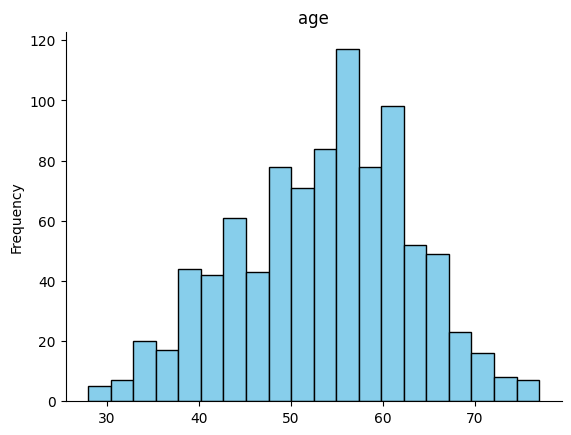

In [ ]:
#age

from matplotlib import pyplot as plt
df_original['age'].plot(kind='hist', bins=20, title='age', color = 'skyblue', edgecolor = 'black')
plt.gca().spines[['top', 'right',]].set_visible(False)

Distribution of Target Variable

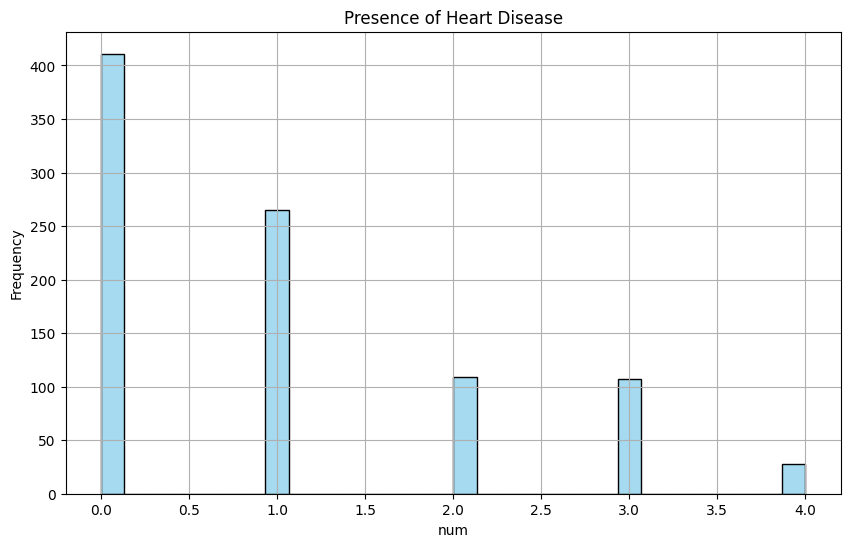

In [ ]:
#Set target variable
target_variable = 'num'

# Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_original[target_variable], bins = 30 , color='skyblue', edgecolor='black')
plt.title('Presence of Heart Disease')
#0 = no heart disease, 1-4: stages of heart disease
plt.xlabel('num')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Correlation Heatmap

ValueError: could not convert string to float: 'Male'

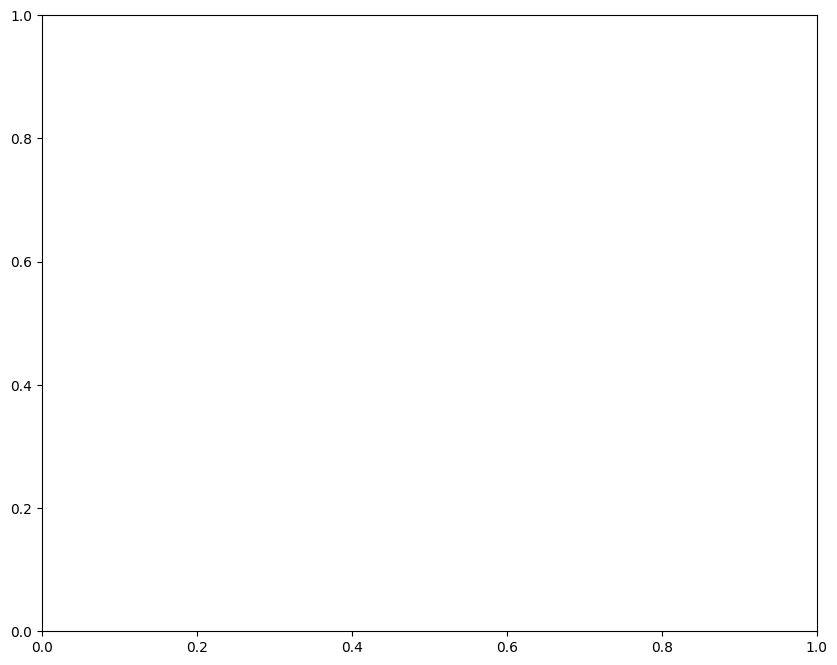

In [ ]:
### Comment/Uncomment the large heatmap for document readibility sake

### Setting up figure space area
fig = plt.figure(figsize=(10,8), dpi=100)
gs = fig.add_gridspec(1,1)

### Adding axes for subplotting
ax0 = fig.add_subplot(gs[0,0])

### Adding background colour
background_color = 'white'
fig.patch.set_facecolor(background_color)


### Creating heatmap of numerical data
corrmat = df_original.corr()
sns.heatmap(ax=ax0, data=corrmat, annot=True, cmap="OrRd",square=True)

### Creating heatmap title
plt.text(x=0, y=-0.5, s='Heatmap of Data', fontsize=30, fontweight='bold', fontfamily='serif')

Boxplots for Continuous Variables

In [ ]:
#resting blood pressure
plt.boxplot(df_original['trestbps'], vert = 0)
plt.title('Resting Blood Pressure (mmHg)')
plt.show()

In [ ]:
#serum cholestrol
plt.boxplot(df_original['chol'], vert = 0)
plt.title('Serum Cholesterol (mg/dl)')
plt.show()

In [ ]:
#maximum heart rate achieved
plt.boxplot(df_original['thalch'], vert = 0)
plt.title('Maximum Heart Rate Achieved')
plt.show()

In [ ]:
#ST depression induced by exercise relative to rest
plt.boxplot(df_original['oldpeak'], vert = 0)
plt.title('ST-depression Induced by Exercise Relative To Rest')
plt.show()

In [ ]:
#number of major vessels
plt.boxplot(df_original['ca'], vert = 0)
plt.title('Number of Major Blood Vessels Colored by Fluoroscopy')
plt.show()

Countplots for Categorical Variables

In [ ]:
#origin (place of study)
sns.countplot(x = 'dataset', data = df_original, palette = "Pastel2")
plt.title('Place of Study')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#sex

sns.countplot(x = 'sex', data = df_original, palette = "Pastel2")
plt.title('Gender of Patients')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#cp chest pain type
sns.countplot(x = 'cp', data = df_original, palette = "Pastel1")
plt.title('Chest Pain')
plt.xlabel('Types of Chest Pain')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#resting electrocardiographic results
sns.countplot(x = 'restecg', data = df_original, palette = "Pastel1")
plt.title('Resting Electrocardiographic (ECG) Results')
plt.xlabel('Type of ECG Result')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#slope
sns.countplot(x = 'slope', data = df_original, palette = "Pastel2")
plt.title('Slope of Peak Exercise ST Segment')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#thal
sns.countplot(x = 'thal', data = df_original, palette = "Pastel2")
plt.title('Thalessemia')
plt.xlabel('Status of Thalessemia') #normal = no thalessemia
plt.ylabel('Frequency')
plt.show()

In [ ]:
#fasting blood sugar level
sns.countplot(x = 'fbs', data = df_original, palette = "Pastel2")
plt.title('Presence of Diabetes')
plt.xlabel('Fasting Blood Sugar Level >120mg/dl')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#correlation of st-depression induced by exercise to heart disease
figsize = (12, 1.2 * len(df_original['num'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_original, x='num', y='oldpeak', inner='box', palette='Dark2')
#sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#correlation of major blood vessels colored by fluoroscopy to heart disease
figsize = (12, 1.2 * len(df_original['num'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_original, x='num', y='ca', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#correlation of major blood vessels colored by fluoroscopy to heart disease
figsize = (12, 1.2 * len(df_original['num'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_original, x='num', y='age', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#thal
sns.displot(x = 'thal', y = 'num', data = df_original, palette = "Pastel2")
plt.title('Thalessemia')
plt.xlabel('Status of Thalessemia') #normal = no thalessemia
plt.ylabel('num')
plt.show()

In [ ]:
# Categorize num into two groups: 0 and 1
df_original['num_group'] = df_original['num'].apply(lambda x: 0 if x == 0 else 1)

# Grouping the DataFrame by 'sex', 'fbs', 'dataset', and 'num_group' and getting the count
grouped_data = df_original.groupby(['sex', 'fbs', 'dataset', 'num_group']).size().unstack(fill_value=0)

# Calculate the total number of 'num' variables for each category
grouped_data['total_num'] = grouped_data.sum(axis=1)

# Select the top 5 categorical variables with the highest number of 'num' variables
top_5_categories = grouped_data.nlargest(5, 'total_num').drop(columns=['total_num'])

# Plotting the heatmap for the top 5 categories
plt.figure(figsize=(10, 6))
sns.heatmap(top_5_categories, cmap='coolwarm', annot=True, fmt='d')

# Adding labels and title
plt.xlabel('Num Group')
plt.ylabel('Categorical Data')
plt.title('Top 5 Categorical Variables with Highest Number of Num Variables')

# Show plot
plt.show()

In [ ]:
import squarify

# Calculate the mean 'num' value for each category in each categorical variable
mean_num_by_sex = df_original.groupby('sex')['num'].mean()
mean_num_by_country = df_original.groupby('dataset')['num'].mean()
mean_num_by_fasting_blood_sugar = df_original.groupby('fbs')['num'].mean()
mean_num_by_presence_of_thalessemia = df_original.groupby('thal')['num'].mean()
mean_num_by_presence_of_chest_pain = df_original.groupby('cp')['num'].mean()
mean_num_by_peak_exercise_ST_segment = df_original.groupby('slope')['num'].mean()
mean_num_by_resting_ecg = df_original.groupby('restecg')['num'].mean()

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(3, 3, 1)
squarify.plot(sizes=mean_num_by_sex, label=mean_num_by_sex.index, alpha=0.6)
plt.title('Mean Num by Sex')

plt.subplot(3, 3, 2)
squarify.plot(sizes=mean_num_by_country, label=mean_num_by_country.index, alpha=0.6)
plt.title('Mean Num by Country')

plt.subplot(3, 3, 3)
squarify.plot(sizes=mean_num_by_fasting_blood_sugar, label=mean_num_by_fasting_blood_sugar.index, alpha=0.6)
plt.title('Mean Num by fbs')

plt.subplot(3, 3, 4)
squarify.plot(sizes=mean_num_by_presence_of_thalessemia, label=mean_num_by_presence_of_thalessemia.index, alpha=0.6)
plt.title('Mean Num by Thalessemia')

plt.subplot(3, 3, 5)
squarify.plot(sizes=mean_num_by_presence_of_chest_pain, label=mean_num_by_presence_of_chest_pain.index, alpha=0.6)
plt.title('Mean Num by Chest Pain')

plt.subplot(3, 3, 6)
squarify.plot(sizes=mean_num_by_peak_exercise_ST_segment, label=mean_num_by_peak_exercise_ST_segment.index, alpha=0.6)
plt.title('Mean Num by Peak Exercise ST Segment')

plt.subplot(3, 3, 7)
squarify.plot(sizes=mean_num_by_resting_ecg, label=mean_num_by_resting_ecg.index, alpha=0.6)
plt.title('Mean Num by Resting ECG')

plt.tight_layout()
plt.show()

In [ ]:
grouped_data = df_original.groupby('sex')['num'].value_counts().unstack(fill_value=0)

# Plotting
grouped_data.plot(kind='bar')

# Adding labels and title
plt.xlabel('Sex')
plt.ylabel('Count of num')
plt.title('Count of num by Sex')

# Show plot
plt.show()

Insight gained from Visualization:



In [ ]:
#The histogram shows distribution of the stages of heart disease
#The Target variable is 'num'
#0 - No heart disease
#1 - Stage 1 Heart Disease
#2 - Stage 2 Heart Disease
#3 - Stage 3 Heart Disease
#4 - Stage 4 Heart Disease

#A majority of the patients are between the ages 50-60

#Box plots show thr distributions of the predictors of heart disease (Numerical data)
#Count plots show the distributions of the predictors of heart disease (Qualitative and Categorical data)

#From the heatmap, we can see that the features with highest correlation to num is oldpeak, ca and age.

#Violinplots confirms that as each of the features increase, so does the stage of heart disease increase.

# Machine Learning (Albert)

Stratified Sampling

In [ ]:
# For machine learning, use encoded_data

X = encoded_data.drop('num', axis=1)
y = encoded_data['num']

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Training and Testing

In [ ]:
# kNN
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Naive Bayes
gnb = GaussianNB()

# Train the classifier
gnb.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

Model Evaluation

In [ ]:
# kNN
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

In [ ]:
# Naive Bayes
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Random Forest
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, y_pred))

Hyperparameter Tuning

In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Parameter grids
knn_param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

gnb_param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

gnb_grid_search = GridSearchCV(gnb, gnb_param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
knn_grid_search.fit(X_train, y_train)

gnb_grid_search.fit(X_train, y_train)

rf_grid_search.fit(X_train, y_train)

In [ ]:
# Best parameters for KNN
print("KNN Best parameters:", knn_grid_search.best_params_)

# Best score for KNN
print("KNN Best score:", knn_grid_search.best_score_)

In [ ]:
# Best parameters for GaussianNB
print("GaussianNB Best parameters:", gnb_grid_search.best_params_)

# Best score for GaussianNB
print("GaussianNB Best score:", gnb_grid_search.best_score_)

In [ ]:
# Best parameters for RF
print("RF Best parameters:", rf_grid_search.best_params_)

# Best score for RF
print("RF Best score:", rf_grid_search.best_score_)

In [ ]:
# Using random forest classifier
rf_best_model = rf_grid_search.best_estimator_
print ('Feature importance ranking\n')
importances = rf_best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best_model.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
variables = [feature for feature in X_train.columns if feature != 'num']
importance_list = []
for f in range(0, 5):
  variable = variables[indices[f]]
  importance_list.append(variable)
  print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))

# Best Model Evaluation (Klyde)


Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Best models
knn_best_model = knn_grid_search.best_estimator_
gnb_best_model = gnb_grid_search.best_estimator_
rf_best_model = rf_grid_search.best_estimator_

In [ ]:
#KNN
y_pred_knn = knn_best_model.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('KNN Confusion Matrix')

plt.show()

In [ ]:
#Naive Bayes
y_pred_naive_bayes = gnb_best_model.predict(X_test)
cm_naive_bayes = confusion_matrix(y_test, y_pred_naive_bayes)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 2)
sns.heatmap(cm_naive_bayes, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Naive Bayes Confusion Matrix')


plt.show()

In [ ]:
#Random Forest
y_pred_random_forest = rf_best_model.predict(X_test)
cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 3)
sns.heatmap(cm_random_forest, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')

plt.show()

ROC Curve

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = np.unique(y_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

In [ ]:
#KNN
# Calculate predicted probabilities
y_proba_knn = knn_best_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(len(classes)):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr_knn[i], tpr_knn[i], label=f'Class {i} (AUC = {roc_auc_knn[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Naive Bayes
y_proba_gnb = gnb_best_model.predict_proba(X_test)

fpr_gnb = dict()
tpr_gnb = dict()
roc_auc_gnb = dict()
for i in range(len(classes)):
    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(y_test_bin[:, i], y_proba_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])


plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr_gnb[i], tpr_gnb[i], label=f'Class {i} (AUC = {roc_auc_gnb[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Random Forest
y_proba_rf = rf_best_model.predict_proba(X_test)

fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(len(classes)):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_proba_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])


plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Class {i} (AUC = {roc_auc_rf[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()